In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import cred as c

In [12]:
engine = create_engine(
    f'postgresql://{c.pg_userid}:{c.pg_password}@{c.pg_host}/{c.pg_db}', 
    connect_args = {'options': '-c search_path=usozmed,public', 'keepalives_idle': 120},
    pool_size=1, 
    max_overflow=0,
    execution_options={ 'isolation_level': 'AUTOCOMMIT' }
)

In [3]:
def quote(s):
  return f"'{s}'"

def exe(sql):
    with engine.connect() as con:
        return pd.read_sql_query(text(sql), con)

## Tables

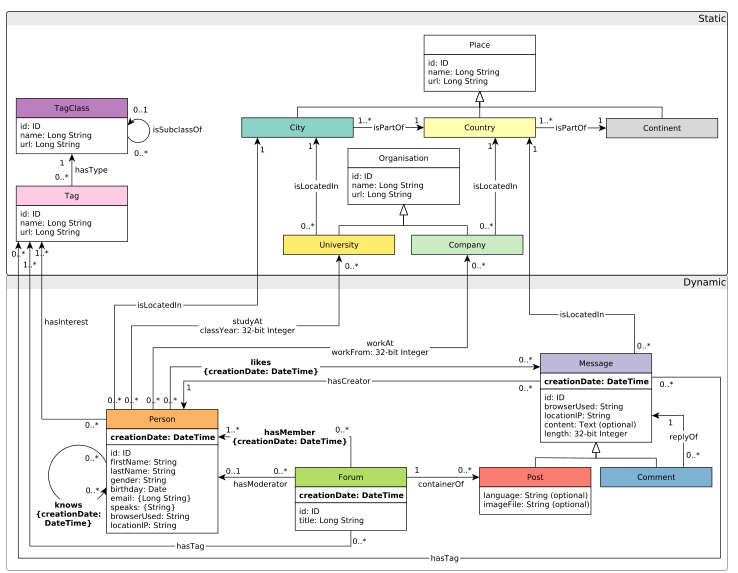

In [4]:
sql = f"""
select
  relname as table_name,
  n_live_tup as row_count
from pg_stat_user_tables
where schemaname = 'usozmed'
order by schemaname, relname;
"""
df = exe(sql)
print(f'{df["row_count"].sum():,}')
df


11,475,072


,table_name,row_count
0,city,1343
1,company,1575
2,country,111
3,forum,100827
4,forum_hasmember_person,2909768
5,forum_hastag_tag,328584
6,message,2860287
7,message_hastag_tag,2928064
8,person,10295
9,person_hasinterest_tag,238052


## Inspect Query

In [13]:

sql = f"""
select count(*) from Message limit 5;
"""
exe(sql)

,count
0,2860664


## Interactive / complex / 1

In [8]:
personId = 14
firstName = quote("Jose")
sql = f"""
SELECT
    Person.id,
    Person.lastName,
    min(distance) AS distance,
    Person.birthday,
    Person.creationDate,
    Person.gender,
    Person.browserUsed,
    Person.locationIP,
    string_to_array(Person.email, ';') AS emails,
    string_to_array(Person.speaks, ';') AS languages,
    City.name,
    (
        SELECT array_agg(ARRAY[University.name, Person_studyAt_University.classYear::text, City.name])
        FROM Person_studyAt_University, University, City
        WHERE Person_studyAt_University.PersonId = Person.id
          AND Person_studyAt_University.UniversityId = University.id
          AND University.LocationPlaceId = City.id
        GROUP BY Person.id
    ) AS university,
    (
        SELECT array_agg(ARRAY[Company.name, Person_workAt_Company.workFrom::text, Country.name])
        FROM Person_workAt_Company, Company, Country
        WHERE Person_workAt_Company.PersonId = Person.id
          AND Person_workAt_Company.CompanyId = Company.id
          AND Company.LocationPlaceId = Country.id
        GROUP BY Person.id
    ) AS company
FROM
    (
        SELECT Person2Id AS id, 1 AS distance
        FROM Person_knows_Person, Person
        WHERE Person1Id = {personId}
          AND Person.id = Person2Id
          AND firstName = {firstName}
        UNION ALL
        SELECT k2.Person2Id AS id, 2 AS distance
        FROM Person_knows_Person k1, Person_knows_Person k2, Person
        WHERE k1.Person1Id = {personId}
          AND k2.Person1Id = k1.Person2Id
          AND Person.id = k2.Person2Id
          AND firstName = {firstName}
          AND Person.id != {personId}-- excluding start person
        UNION ALL
        SELECT k3.Person2Id AS id, 3 AS distance
        FROM Person_knows_Person k1, Person_knows_Person k2, Person_knows_Person k3, Person
        WHERE k1.Person1Id = {personId}
          AND k2.Person1Id = k1.Person2Id
          AND k2.Person2Id = k3.Person1Id
          AND Person.id = k3.Person2Id
          AND firstName = {firstName}
          AND Person.id != {personId}-- excluding start person
    ) tmp, Person, City
  WHERE Person.id = tmp.id
    AND Person.LocationCityId = City.id
  GROUP BY Person.id, lastName, birthday, creationDate, gender, browserUsed, locationIP, City.name
  ORDER BY distance, lastName, Person.id
  LIMIT 20
;
"""
# # print(sql)
exe(sql)


,id,lastname,distance,birthday,creationdate,gender,browserused,locationip,emails,languages,name,university,company
0,30786325577740,Alonso,2,1987-08-18,2012-06-26 12:37:35.179000+00:00,female,Internet Explorer,196.1.135.241,"[Jose30786325577740@hotmail.com, Jose307863255...","[es, en]",Jagüey_Grande,"[[University_of_Cienfuegos, 2008, Cienfuegos]]","[[Cubana_de_Aviación, 2009, Cuba], [Aerogaviot..."
1,19791209308329,Dom Pedro II,2,1989-07-25,2011-08-21 18:49:52.400000+00:00,male,Firefox,177.6.108.225,"[Jose19791209308329@gmail.com, Jose19791209308...","[pt, en]",Manaus,[[Pontifical_Catholic_University_of_Rio_de_Jan...,[[TABA_–_Transportes_Aéreos_da_Bacia_Amazônica...
2,24189255818493,Fernandez,2,1987-12-15,2011-11-21 21:34:06.857000+00:00,female,Chrome,200.55.175.244,"[Jose24189255818493@gmail.com, Jose24189255818...","[es, en]",Pinar_del_Río,"[[University_of_Ciego_de_Ávila, 2008, Ciego_de...","[[Cubana_de_Aviación, 2009, Cuba], [Aero_Carib..."
3,8796093031783,Go,2,1988-01-01,2010-10-04 21:12:26.204000+00:00,female,Safari,122.144.73.210,[Jose8796093031783@yahoo.com],[en],Tagbilaran,"[[University_of_Santo_Tomas, 2008, Sampaloc]]",None
4,32985348838034,Gonzalez,2,1988-09-02,2012-08-15 09:54:21.465000+00:00,male,Internet Explorer,187.161.124.7,[Jose32985348838034@gmx.com],"[es, en]",Montemorelos,[[Centro_de_Investigación_y_Desarrollo_Tecnoló...,"[[Nova_Air, 2009, Mexico], [Avolar, 2009, Mexi..."
5,28587302328069,Gutierrez,2,1983-03-30,2012-04-07 03:02:39.016000+00:00,female,Chrome,190.6.90.133,"[Jose28587302328069@gmail.com, Jose28587302328...","[es, en]",Marianao,"[[University_of_Cienfuegos, 2005, Cienfuegos]]","[[Cubana_de_Aviación, 2007, Cuba], [Aerogaviot..."
6,28587302325374,Pereira,2,1985-09-05,2012-03-23 16:01:10.975000+00:00,male,Internet Explorer,192.207.195.217,[Jose28587302325374@gmail.com],"[pt, en]",Uberlândia,None,"[[Abaeté_Linhas_Aéreas, 2008, Brazil]]"
7,15393162797982,Santos,2,1988-12-23,2011-04-19 13:39:40.370000+00:00,male,Chrome,146.134.201.212,"[Jose15393162797982@gmail.com, Jose15393162797...","[pt, en]",Londrina,"[[Federal_University_of_Amazonas, 2009, Manaus]]","[[TAM_–_Táxi_Aéreo_Marília, 2011, Brazil]]"
8,10995116286213,Silva,2,1981-03-01,2010-11-27 23:02:12.135000+00:00,male,Firefox,85.243.239.175,"[Jose10995116286213@gmx.com, Jose1099511628621...","[pt, en]",Funchal,"[[Instituto_Superior_de_Engenharia_de_Coimbra,...","[[Air_Atlantis, 2003, Portugal], [TAP_Portugal..."
9,24189255818800,Alonso,3,1983-11-22,2011-11-10 22:08:12.551000+00:00,female,Firefox,200.5.14.118,"[Jose24189255818800@gmail.com, Jose24189255818...","[es, en]",Ciego_de_Ávila,"[[University_of_Santiago_de_Cuba, 2004, Santia...","[[Aero_Caribbean, 2005, Cuba]]"


## Interactive / complex / 2

In [9]:
personId = 14
maxDate = f"{quote('2010-10-16')}::date"
sql = f"""
SELECT
    Person.id,
    Person.firstName,
    Person.lastName,
    Message.id,
    coalesce(Message.imageFile, Message.content),
    Message.creationDate
FROM
    Person,
    Message,
    Person_knows_Person
WHERE Person.id = Message.CreatorPersonId
  AND Message.creationDate < {maxDate}
  AND Person1Id = {personId}
  AND Person2Id = Person.id
ORDER BY Message.creationDate DESC, Message.id ASC
LIMIT 20
;
"""
# print(sql)
exe(sql)

,id,firstname,lastname,id,coalesce,creationdate
0,8796093030850,Monja,Tsiranana,549758485894,"About Rumi, d in the year Rumi was born, his f...",2010-10-15 05:25:54.607000+00:00
1,8796093030850,Monja,Tsiranana,549758485736,"About Rumi, Dervishes, famous for its Sufi da...",2010-10-15 00:09:18.473000+00:00
2,8796093030850,Monja,Tsiranana,549758483700,"About Rumi, nd cultural language in the Persia...",2010-10-13 14:29:57.457000+00:00
3,4398046517420,Irina,Markov,549756749671,"About Jorge Luis Borges, ry. In fact, critic A...",2010-10-13 08:23:43.715000+00:00
4,2199023264850,Gheorghe,Popescu,549756812145,duh,2010-10-12 16:37:39.740000+00:00
5,8796093030850,Monja,Tsiranana,549758486491,"About Rumi, glish-speaking world simply as Rum...",2010-10-12 08:34:23.553000+00:00
6,2199023264850,Gheorghe,Popescu,549755938337,thanks,2010-10-12 04:56:32.295000+00:00
7,4398046517420,Irina,Markov,549756749419,"About Jorge Luis Borges, universal de la inAbo...",2010-10-12 04:09:03.624000+00:00
8,8796093030850,Monja,Tsiranana,549758482166,"About Rumi, al sphere of Khorasan, the eastern...",2010-10-11 17:52:56.133000+00:00
9,8796093030850,Monja,Tsiranana,549758487306,"About Rumi, ther Pakistani languages written i...",2010-10-11 07:37:58.659000+00:00


## Interactive / complex / 3

In [10]:
startDate = f"{quote('2010-06-01')}::date"
countryXName = quote("Angola")
countryYName = quote("Colombia")
durationDays = 28
sql = f"""
SELECT
    Person.id AS otherPersonId,
    Person.firstName AS otherPersonFirstName,
    Person.lastName AS otherPersonLastName,
    ct1 AS xCount,
    ct2 AS yCount,
    totalcount AS count
FROM
    (
        SELECT Person2Id
        FROM Person_knows_Person
        WHERE Person1Id = {personId}
        UNION
        SELECT k2.Person2Id
        FROM Person_knows_Person k1, Person_knows_Person k2
        WHERE k1.Person1Id = {personId}
          AND k1.Person2Id = k2.Person1Id
          AND k2.Person2Id <> {personId}
    ) friend,
    Person,
    City,
    Country,
    (
        SELECT
            chn.CreatorPersonId,
            ct1,
            ct2,
            ct1 + ct2 AS totalcount
        FROM
            (
                SELECT CreatorPersonId AS CreatorPersonId, count(*) AS ct1
                FROM Message, Country
                WHERE LocationCountryId = Country.id
                  AND Country.name = {countryXName}
                  AND Message.creationDate >= {startDate}
                  AND Message.creationDate < ({startDate} + INTERVAL '1 days' * {durationDays})
                GROUP BY CreatorPersonId
            ) chn,
            (
                SELECT CreatorPersonId AS CreatorPersonId, count(*) AS ct2
                FROM Message, Country
                WHERE LocationCountryId = Country.id
                  AND Country.name = {countryYName}
                  AND Message.creationDate >= {startDate}
                  AND Message.creationDate < ({startDate} + INTERVAL '1 days' * {durationDays})
                GROUP BY CreatorPersonId
            ) ind
        WHERE chn.CreatorPersonId = IND.CreatorPersonId
    ) cpc
WHERE friend.Person2Id = Person.id
  AND Person.LocationCityId = City.id
  AND City.PartOfCountryId = Country.id
  AND Country.name <> {countryXName}
  AND Country.name <> {countryYName}
  AND friend.Person2Id = cpc.CreatorPersonId
ORDER BY totalcount DESC, Person.id ASC
LIMIT 20
;
"""
# print(sql)
exe(sql)

,otherpersonid,otherpersonfirstname,otherpersonlastname,xcount,ycount,count


## Interactive / complex / 4

In [14]:
personId = 14
startDate = f"{quote('2010-10-01')}::date"
durationDays = 31

sql = f"""
SELECT name, count(*) AS postCount
FROM
    Tag,
    Message,
    Message_hasTag_Tag recent,
    Person_knows_Person
WHERE Message.id = recent.MessageId
  AND recent.TagId = Tag.id
  AND Message.CreatorPersonId = Person2Id
  AND ParentMessageId IS NULL -- post, not comment
  AND Person1Id = {personId}
  AND Message.creationDate >= {startDate}
  AND Message.creationDate < ({startDate} + INTERVAL '1 days' * {durationDays})
  AND NOT EXISTS (
        SELECT *
        FROM (
            SELECT DISTINCT TagId
            FROM Message, Message_hasTag_Tag, Person_knows_Person
            WHERE Person1Id = {personId}
              AND Person2Id = CreatorPersonId
              AND ParentMessageId IS NULL -- post, not comment
              AND Message_hasTag_Tag.MessageId = Message.id
              AND Message.creationDate < {startDate}
        ) tags
        WHERE tags.TagId = recent.TagId
      )
GROUP BY name
ORDER BY postCount DESC, name ASC
LIMIT 10
;
"""
# print(sql)
exe(sql)

,name,postcount
0,Rumi,15
1,Ernest_Hemingway,1
2,Plato,1
3,Pope_Pius_IX,1
4,Wolfgang_Amadeus_Mozart,1


## Interactive / complex / 5

In [15]:
personId = 14
minDate = f"{quote('2010-11-01')}::date"

sql = f"""
SELECT
    title,
    count(id) AS postCount
FROM
    (
        SELECT title, Forum.id AS ForumId, friend.Person2Id
        FROM Forum, Forum_hasMember_Person,
        (
            SELECT Person2Id
            FROM Person_knows_Person
            WHERE Person1Id = {personId}
            UNION
            SELECT k2.Person2Id
            FROM Person_knows_Person k1
            JOIN Person_knows_Person k2
              ON k1.Person2Id = k2.Person1Id
            WHERE k1.Person1Id =  {personId}
              AND k2.Person2Id <> {personId}
        ) friend
        WHERE Forum.id = Forum_hasMember_Person.ForumId
          AND Forum_hasMember_Person.PersonId = friend.Person2Id
          AND Forum_hasMember_Person.creationDate >= {minDate}
    ) tmp
LEFT JOIN Message
       ON tmp.ForumId = Message.ContainerForumId
      AND CreatorPersonId = tmp.Person2Id
      AND Message.ParentMessageId IS NULL
GROUP BY ForumId, title
ORDER BY postCount DESC, ForumId ASC
LIMIT 20
;
"""
# print(sql)
exe(sql)

,title,postcount
0,Group for James_Buchanan in Tabriz,69
1,Group for Sergei_Prokofiev in Pleiku,48
2,Group for Carl_Linnaeus in Toamasina,46
3,Group for Dante_Alighieri in Dhamar,40
4,Group for Che_Guevara in Kalyani,33
5,Group for Henry_II_of_England in Orlando,32
6,Group for Kurt_Cobain in Cancún,31
7,Group for Henry_Fonda in Awasa,31
8,Group for Bob_Hope in Liverpool,30
9,Group for Louis_XIV_of_France in Elpitiya,30


## Interactive / complex / 6

In [43]:
personId = 14
tagName = quote("Carl_Gustaf_Emil_Mannerheim")

sql = f"""
SELECT name, count(*) AS postcount
FROM
    Tag,
    Message_hasTag_Tag,
    Message,
    (
        SELECT Person2Id
        FROM Person_knows_Person
        WHERE Person1Id = {personId}
        UNION
        SELECT k2.Person2Id
        FROM Person_knows_Person k1, Person_knows_Person k2
        WHERE k1.Person1Id = {personId}
          AND k1.Person2Id = k2.Person1Id
          AND k2.Person2Id <> {personId}
    ) friend
WHERE CreatorPersonId = friend.Person2Id
  AND ParentMessageId IS NULL -- post, not comment
  AND Message.id = Message_hasTag_Tag.MessageId
  AND Message_hasTag_Tag.TagId = Tag.id
  AND name <> {tagName}
  AND EXISTS (
          SELECT *
          FROM Tag, Message_hasTag_Tag
          WHERE Message.id = Message_hasTag_Tag.MessageId
            AND Message_hasTag_Tag.TagId = Tag.id
            AND Tag.name = {tagName}
      )
GROUP BY name
ORDER BY postCount DESC, name ASC
LIMIT 10
;
"""
# print(sql)
exe(sql)

,name,postcount
0,Cuba,5
1,Poland,4
2,Roman_Polanski,4
3,Bosnia_and_Herzegovina,3
4,England,3
5,Gordon_Brown,3
6,Henry_II_of_England,3
7,Honduras,3
8,Jim_Carrey,3
9,Jimmy_Carter,3


## Interactive / complex / 7

In [21]:
personId = 14

sql = f"""
SELECT
    Person.id,
    firstName,
    lastName,
    l.creationDate,
    Message.id,
    coalesce(imageFile, content),
    CAST(floor(EXTRACT(EPOCH FROM (l.creationDate - Message.creationDate))) AS INTEGER) / 60 AS minutesLatency,
    (
        CASE WHEN EXISTS (
            SELECT 1
            FROM Person_knows_Person
            WHERE Person1Id = {personId}
              AND Person2Id = Person.id
        ) THEN 0 ELSE 1 END
    ) AS isNew
FROM
    (
        SELECT PersonId, max(Person_likes_Message.creationDate) AS creationDate
        FROM Person_likes_Message, Message
        WHERE Person_likes_Message.MessageId = Message.id
          AND Message.CreatorPersonId = {personId}
        GROUP BY PersonId
        ORDER BY creationDate DESC, PersonId ASC
        LIMIT 20
    ) tmp,
    Message,
    Person,
    Person_likes_Message AS l
WHERE Person.id = tmp.PersonId
  AND tmp.PersonId = l.PersonId
  AND tmp.creationDate = l.creationDate
  AND l.MessageId = Message.id
ORDER BY l.creationDate DESC, Person.id ASC
;
"""
# print(sql)
exe(sql)

,id,firstname,lastname,creationdate,id,coalesce,minuteslatency,isnew
0,6597069773776,Antonio,Reyes,2012-11-28 03:42:32.365000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",9704,1
1,28587302328393,Yaroslav,Foxx,2012-11-28 01:01:20.533000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",9543,1
2,2174,Gisela,Aguirre,2012-11-26 15:58:16.134000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",7560,1
3,30786325587193,Zaenal,Gallagher,2012-11-26 06:11:50.345000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",6973,1
4,14,Hossein,Forouhar,2012-11-26 03:50:07.027000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",6832,1
5,13194139542928,Andre,Buysse,2012-11-25 18:10:16.665000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",6252,1
6,4398046519782,Mario,Arbelaez,2012-11-25 10:57:57.364000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",5819,1
7,10995116279067,George,Kovacs,2012-11-24 23:57:12.236000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",5159,1
8,15393162797716,James,Johnson,2012-11-24 06:07:36.830000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",4089,1
9,15393162789340,Bing,Liu,2012-11-23 20:27:28.074000+00:00,2336462582770,"About Hosni Mubarak, ecretary General of Non-A...",3509,1


## Interactive / complex / 8

In [22]:
personId = 14

sql = f"""
SELECT
    m1.CreatorPersonId,
    firstName,
    lastName,
    m1.creationDate,
    m1.id,
    m1.content
FROM
    Message m1,
    Message m2,
    Person
WHERE m1.ParentMessageId = m2.id
  AND m2.CreatorPersonId = {personId}
  AND Person.Id = m1.CreatorPersonId
ORDER BY
    m1.creationDate DESC,
    m1.id ASC
LIMIT 20
;
"""
# print(sql)
exe(sql)

,creatorpersonid,firstname,lastname,creationdate,id,content
0,6597069773131,Wei,Huang,2012-11-27 17:35:48.755000+00:00,2336464450429,right
1,35184372091853,Ayesha,Ahmed,2012-11-27 12:23:31.965000+00:00,2336462901619,great
2,2199023265672,Rahul,Kumar,2012-11-26 17:34:33.315000+00:00,2336464450316,roflol
3,35184372095846,Rudolf,Hoffmann,2012-11-26 09:40:29.584000+00:00,2336462209028,LOL
4,35184372095846,Rudolf,Hoffmann,2012-11-26 02:21:29.262000+00:00,2336462209025,yes
5,4398046516877,Chengdong,Li,2012-11-23 09:20:08.477000+00:00,2336462582344,no way!
6,15393162794226,Kunal,Sharma,2012-11-20 22:48:00.153000+00:00,2336462583007,"About Edward IV of England, th Knight of the O..."
7,2174,Gisela,Aguirre,2012-11-20 17:38:34.224000+00:00,2336462582695,great
8,4398046520278,John,Cruz,2012-11-20 16:18:25.575000+00:00,2336462583010,no
9,19791209305841,Wilson,Agudelo,2012-11-20 14:35:04.985000+00:00,2336462584179,fine


## Interactive / complex / 9

In [23]:
personId = 14
maxDate = f"{quote('2010-11-16')}::date"

sql = f"""
SELECT
    Person.id,
    firstName,
    lastName,
    Message.id,
    coalesce(imageFile, content),
    Message.creationDate
FROM
    (
        SELECT Person2Id
        FROM Person_knows_Person
        WHERE Person1Id = {personId}
        UNION
        SELECT k2.Person2Id
        FROM Person_knows_Person k1, Person_knows_Person k2
        WHERE k1.Person1Id = {personId}
          AND k1.Person2Id = k2.Person1Id
          AND k2.Person2Id <> {personId}
    ) friend,
    Person,
    Message
WHERE Person.id = CreatorPersonId
  AND Person.id = friend.Person2Id
  AND Message.creationDate < {maxDate}
ORDER BY Message.creationDate DESC, Message.id ASC
LIMIT 20
;
"""
# print(sql)
exe(sql)

,id,firstname,lastname,id,coalesce,creationdate
0,8796093030850,Monja,Tsiranana,687197437519,"About Rumi, s written in Perso/Arabic script e...",2010-11-15 18:56:14.419000+00:00
1,6597069774986,Joe,Fox,687197141536,"About Adolf Hitler, orld War I, during which h...",2010-11-15 15:51:23.813000+00:00
2,8796093027159,Ivan,Gusev,687197365413,"About Elvis Presley, ions of songs, many from ...",2010-11-15 07:03:24.020000+00:00
3,2199023265941,Sergio,Abascal,687195697823,great,2010-11-15 05:24:52.675000+00:00
4,2199023265941,Sergio,Abascal,687195508636,"About Mahathir Mohamad, of the US, Britain and...",2010-11-15 00:50:20.352000+00:00
5,6597069771115,Ami,Chatterjee,687197025147,"About Che Guevara, rinsic result of capitalism...",2010-11-15 00:25:29.814000+00:00
6,10995116286081,Ab,Dijk,687197727823,photo687197727823.jpg,2010-11-14 22:39:10.077000+00:00
7,10995116286081,Ab,Dijk,687197727822,photo687197727822.jpg,2010-11-14 22:39:09.077000+00:00
8,10995116286081,Ab,Dijk,687197727821,photo687197727821.jpg,2010-11-14 22:39:08.077000+00:00
9,10995116286081,Ab,Dijk,687197727820,photo687197727820.jpg,2010-11-14 22:39:07.077000+00:00


## Interactive / complex / 10

In [28]:
personId = 14
month = 5

sql = f"""
SELECT
    Person.id,
    firstName,
    lastName,
    (
        SELECT count(DISTINCT Message.id)
        FROM Message, Message_hasTag_Tag pt1
        WHERE CreatorPersonId = Person.id
          AND ParentMessageId IS NULL -- post, not comment
          AND Message.id = pt1.MessageId
          AND EXISTS (
              SELECT *
              FROM Person_hasInterest_Tag
              WHERE Person_hasInterest_Tag.PersonId = {personId}
                AND Person_hasInterest_Tag.TagId = pt1.TagId
          )
    ) -
    (
        SELECT count(*)
        FROM Message
        WHERE CreatorPersonId = Person.id
          AND ParentMessageId IS NULL -- post, not comment
          AND NOT EXISTS (
              SELECT *
              FROM Person_hasInterest_Tag, Message_hasTag_Tag
              WHERE Person_hasInterest_Tag.PersonId = {personId}
                AND Person_hasInterest_Tag.TagId = Message_hasTag_Tag.TagId
                AND Message_hasTag_Tag.MessageId = Message.id
          )
    ) AS commonInterestScore,
    gender,
    City.name
FROM
    Person,
    City,
    (
        SELECT DISTINCT k2.Person2Id
        FROM Person_knows_Person k1, Person_knows_Person k2
        WHERE k1.Person1Id = {personId}
          AND k1.Person2Id = k2.Person1Id
          AND k2.Person2Id <> {personId}
          AND NOT EXISTS (
              SELECT *
              FROM Person_knows_Person
              WHERE Person1Id = {personId}
                AND Person2Id = k2.Person2Id
          )
    ) f
WHERE LocationCityId = City.id
  AND Person.id = f.Person2Id
  AND (
      (extract(month FROM birthday) = {month}          AND (CASE WHEN extract(day FROM birthday) >= 21 THEN true ELSE false END))
   OR (extract(month FROM birthday) = {month} % 12 + 1 AND (CASE WHEN extract(day FROM birthday) <  22 THEN true ELSE false END))
  )
ORDER BY commonInterestScore DESC, Person.id
LIMIT 10
;
"""
# print(sql)
exe(sql)

,id,firstname,lastname,commoninterestscore,gender,name
0,10995116284152,Faiz,Qaderi,6,female,Gardēz
1,21990232564358,Alexander,Ivanov,0,male,Ulan-Ude
2,30786325577908,Aden,Ben-Tzur,0,male,Zinjibar
3,32985348837818,Ning,Zhang,0,female,Foshan
4,32985348841688,Karl,Fischer,0,female,Stuttgart
5,32985348843215,Abdoulatifou,Muni,0,male,Antsiranana
6,35184372089959,Imtiaz,Khan,0,female,Sukkur
7,35184372090120,Anucha,Paphunga,0,female,Songkhla
8,35184372090265,Barry,Wang,0,female,Taichung
9,35184372093350,Deepak,Singh,0,male,Kodambakkam


## Interactive / complex / 11

In [29]:
personId = 14
workFromYear = 2011
countryName = quote("Hungary")

sql = f"""
SELECT
    Person.id,
    firstName,
    lastName,
    Company.name,
    Person_workAt_Company.workFrom
FROM
    Person,
    Person_workAt_Company,
    Company,
    Country,
    (
        SELECT Person2Id
        FROM Person_knows_Person
        WHERE Person1Id = {personId}
        UNION
        SELECT k2.Person2Id
        FROM Person_knows_Person k1, Person_knows_Person k2
        WHERE k1.Person1Id = {personId}
          AND k1.Person2Id = k2.Person1Id
          AND k2.Person2Id <> {personId}
    ) friend
WHERE Person.id = friend.Person2Id
  AND Person.id = Person_workAt_Company.PersonId
  AND Person_workAt_Company.CompanyId = Company.id
  AND Person_workAt_Company.workFROM < {workFromYear}
  AND Country.id = Company.LocationPlaceId
  AND Country.name = {countryName}
ORDER BY Person_workAt_Company.workFrom, Person.id, Company.name DESC
LIMIT 10
;
"""
# print(sql)
exe(sql)

,id,firstname,lastname,name,workfrom
0,26388279074382,Laszlo,Nagy,CityLine_Hungary,2000
1,26388279070147,George,Nagy,Budapest_Aircraft_Service,2001
2,26388279074382,Laszlo,Nagy,Budapest_Aircraft_Service,2001
3,26388279076565,Anna,Hayvoronsky,Travel_Service_(Hungary),2001
4,26388279070147,George,Nagy,Travel_Service_(Hungary),2002
5,26388279070147,George,Nagy,Malév_Hungarian_Airlines,2002
6,26388279074382,Laszlo,Nagy,ABC_Air_Hungary,2002
7,13194139540056,Ferenc,Toth,Wizz_Air,2003
8,13194139540056,Ferenc,Toth,Travel_Service_(Hungary),2003
9,24189255815466,Gyula,Nagy,Budapest_Aircraft_Service,2003


## Interactive / complex / 12

In [31]:
personId = 14
tagClassName = quote("Monarch")

sql = f"""
WITH RECURSIVE extended_tags(s_subtagclassid, s_supertagclassid) AS (
    SELECT id, id
    FROM tagclass
    UNION
    SELECT tc.id, t.s_supertagclassid
      FROM tagclass tc, extended_tags t
     WHERE tc.SubclassOfTagClassId = t.s_subtagclassid
)
SELECT
    Person.id,
    firstName,
    lastName,
    array_agg(DISTINCT name),
    count(DISTINCT m1.id) AS replyCount
FROM
    Person,
    Message m1,
    Person_knows_Person,
    Message m2,
    Message_hasTag_Tag, 
    (
        SELECT DISTINCT id, name
        FROM tag
        WHERE TypeTagClassId IN (
            SELECT DISTINCT s_subtagclassid
            FROM extended_tags k, tagclass
            WHERE id = k.s_supertagclassid
              AND name = {tagClassName}
            )
    ) selected_tags
WHERE Person1Id = {personId}
  AND Person2Id = Person.id
  AND Person.id = m1.CreatorPersonId
  AND m1.ParentMessageId = m2.id
  AND m2.ParentMessageId IS NULL
  AND m2.id = Message_hasTag_Tag.MessageId
  AND Message_hasTag_Tag.TagId = selected_tags.id
GROUP BY Person.id, Person.firstName, person.lastName
ORDER BY replyCount DESC, Person.id ASC
LIMIT 20
;
"""
# print(sql)
exe(sql)

,id,firstname,lastname,array_agg,replycount
0,8796093030850,Monja,Tsiranana,"[Alexander_the_Great, Ashoka, Augustus, Consta...",104
1,30786325578027,Otto,Becker,"[Alexander_the_Great, Ashoka, Augustus, Claudi...",81
2,21990232559659,Baruch,Dego,"[Alexander_the_Great, Augustus, Claudius, Cons...",68
3,26388279070147,George,Nagy,"[Alexander_the_Great, Aurelian, Claudius, Cons...",54
4,2199023264850,Gheorghe,Popescu,"[Ahmad_Shah_Durrani, Alexander_the_Great, Augu...",53
5,35184372095846,Rudolf,Hoffmann,"[Alexander_the_Great, Augustus, Aurelian, Cons...",27
6,4398046517420,Irina,Markov,"[Augustus, Claudius, Constantine_the_Great, Da...",26
7,8796093028037,René,Arnaud,"[Ashoka, Aurelian, Dalai_Lama, David, Genghis_...",15
8,10995116286528,Hossein,Karimi,"[Ashoka, Genghis_Khan, Marcus_Aurelius, Saladi...",15
9,24189255818481,Lev,Feltsman,"[Ashoka, Augustus, Diocletian, Genghis_Khan, J...",14


## Interactive / complex / 13

In [32]:
person1Id = 100
person2Id = 200

sql = f"""
WITH RECURSIVE
-- Bidirectional breadth first search
bfs(dir, node, depth) AS (
    SELECT dd,nn,ll FROM (VALUES (false, {person1Id}::bigint, 0), (true, {person2Id}::bigint, 0)) t(dd,nn,ll)
    UNION ALL
    (
        with
        rec AS (SELECT dir, node, depth FROM bfs),
        md AS (SELECT max(depth) AS d FROM rec),
        last AS (SELECT dir, node, depth FROM rec WHERE depth = (SELECT d FROM md)),
        new AS (
            SELECT dir, pkp.person2id AS dst, min(depth) + 1 AS md
            FROM last, person_knows_person pkp
            WHERE last.node = pkp.person1id AND pkp.person2id not in (SELECT node FROM rec WHERE last.dir = rec.dir)
            group by dir, pkp.person2id
        )
        SELECT dir, dst, md
        FROM
            (SELECT dir, dst, md FROM new
            union all
            SELECT dir, node, depth
            FROM rec) t
        WHERE true 
            AND EXISTS (SELECT * FROM new)
            AND NOT EXISTS (
                    SELECT *
                    FROM last r1, rec r2
                    WHERE r1.dir = true AND r2.dir = false AND r1.node = r2.node
                )

    )
),
md AS (SELECT max(depth) AS d FROM bfs),
found(depth) AS (
    SELECT min(r1.depth + r2.depth)
    FROM bfs r1, bfs r2
    WHERE r1.depth = (SELECT d FROM md) and
          r1.dir = true AND r2.dir = false AND r1.node = r2.node

)
SELECT coalesce((SELECT depth FROM found), -1)
;

"""
# print(sql)
exe(sql)

,coalesce
0,-1


## Interactive / complex / 14

In [33]:
person1Id = 100
person2Id = 200

sql = f"""
with recursive
pathb(a, b, w) AS (
    SELECT least(c.creatorpersonid, p.creatorpersonid) AS a, greatest(c.creatorpersonid, p.creatorpersonid) AS b, greatest(round(40 - sqrt(count(*)))::bigint, 1)  AS w
    FROM message c, message p
    WHERE c.parentmessageid = p.id AND EXISTS (SELECT * FROM person_knows_person WHERE person1id = c.creatorpersonid AND person2id = p.creatorpersonid)
    group by a, b
),
path(src, dst, w) AS (
    SELECT a, b, w
    FROM pathb
    union all
    SELECT b, a, w
    FROM pathb
),
shorts(dir, gsrc, dst, prev, w, dead, iter) AS (
    SELECT sdir, sgsrc, sdst, sdst, sw, sdead, siter
    FROM
        (VALUES
             (false, {person1Id}::bigint, {person1Id}::bigint, 0::bigint, false, 0),
             (true, {person2Id}::bigint, {person2Id}::bigint, 0::bigint, false, 0))
        t(sdir, sgsrc, sdst, sw, sdead, siter)
    union all
    (
        with
        ss AS (SELECT * FROM shorts),
        toExplore AS (SELECT * FROM ss WHERE dead = false order by w limit 1000),
        -- assumes graph is undirected
        newPoints(dir, gsrc, dst, prev, w, dead) AS (
            SELECT e.dir, e.gsrc AS gsrc, p.dst AS dst, p.src as prev, e.w + p.w AS w, false AS dead
            FROM path p join toExplore e on (e.dst = p.src)
            UNION ALL
            SELECT dir, gsrc, dst, prev, w, dead OR EXISTS (SELECT * FROM toExplore e WHERE e.dir = o.dir AND e.gsrc = o.gsrc AND e.dst = o.dst) FROM ss o
        ),
        fullTable AS (
            SELECT DISTINCT ON(dir, gsrc, dst) dir, gsrc, dst, prev, w, dead
            FROM newPoints
            ORDER BY dir, gsrc, dst, w, dead, prev DESC
        ),
        found AS (
            SELECT min(l.w + r.w) AS w
            FROM fullTable l, fullTable r
            WHERE l.dir = false AND r.dir = true AND l.dst = r.dst
        )
        SELECT dir,
               gsrc,
               dst,
               prev,
               w,
               dead OR (coalesce(t.w > (SELECT f.w/2 FROM found f), false)),
               e.iter + 1 AS iter
        FROM fullTable t, (SELECT iter FROM toExplore limit 1) e
    )
),
ss(dir, gsrc, dst, prev, w, iter) AS (
    SELECT dir, gsrc, dst, prev, w, iter FROM shorts WHERE iter = (SELECT max(iter) FROM shorts)
),
result(f, t, inter, w) AS (
    SELECT l.gsrc, r.gsrc, l.dst, l.w + r.w
    FROM ss l, ss r
    WHERE l.dir = false AND r.dir = true AND l.dst = r.dst
    ORDER BY l.w + r.w
    LIMIT 1
),
sp1(arr, cur) as (
    SELECT ARRAY[inter]::bigint[], inter FROM result
    UNION ALL
    SELECT array_prepend(ss.prev, sp1.arr), ss.prev
    FROM ss, sp1
    WHERE ss.dir = false AND ss.dst = sp1.cur AND ss.prev <> ss.dst
),
sp2(arr, cur) as (
    SELECT (SELECT arr FROM sp1 WHERE cur = (SELECT f FROM result)), (SELECT inter FROM result)
    UNION ALL
    SELECT array_append(sp2.arr, ss.prev), ss.prev
    FROM ss, sp2
    WHERE ss.dir = true AND ss.dst = sp2.cur AND ss.prev <> ss.dst
)
SELECT sp2.arr AS personIdsInPath, result.w AS pathWeight
FROM result, sp2
WHERE sp2.cur = result.t
;
"""
# print(sql)
exe(sql)

,personidsinpath,pathweight


## BI Read 1

In [34]:
datetime = f"{quote('2011-12-01T00:00:00.000+00:00')}::timestamp"


sql = f"""
WITH
  message_count AS (
    SELECT 0.0 + count(*) AS cnt
      FROM Message
     WHERE creationDate < {datetime}
)
, message_prep AS (
    SELECT extract(year from creationDate) AS messageYear
         , ParentMessageId IS NOT NULL AS isComment
         , CASE
             WHEN length <  40 THEN 0 -- short
             WHEN length <  80 THEN 1 -- one liner
             WHEN length < 160 THEN 2 -- tweet
             ELSE                   3 -- long
           END AS lengthCategory
         , length
      FROM Message
     WHERE creationDate < {datetime}
       AND content IS NOT NULL
)
SELECT messageYear, isComment, lengthCategory
     , count(*) AS messageCount
     , avg(length::bigint) AS averageMessageLength
     , sum(length::bigint) AS sumMessageLength
     , count(*) / mc.cnt AS percentageOfMessages
  FROM message_prep
     , message_count mc
 GROUP BY messageYear, isComment, lengthCategory, mc.cnt
 ORDER BY messageYear DESC, isComment ASC, lengthCategory ASC
;
"""
# print(sql)
exe(sql)

,messageyear,iscomment,lengthcategory,messagecount,averagemessagelength,summessagelength,percentageofmessages
0,2011.0,False,2,70448,105.409110,7425861.0,0.101938
1,2011.0,False,3,8632,204.504518,1765283.0,0.012491
2,2011.0,True,0,112566,4.196294,472360.0,0.162883
3,2011.0,True,1,16659,76.488925,1274229.0,0.024106
4,2011.0,True,2,37465,92.548245,3467320.0,0.054212
5,2011.0,True,3,2434,174.469187,424658.0,0.003522
6,2010.0,False,2,30342,105.316986,3195528.0,0.043905
7,2010.0,False,3,3695,204.186198,754468.0,0.005347
8,2010.0,True,0,8189,4.179875,34229.0,0.011849
9,2010.0,True,1,1238,76.395800,94578.0,0.001791


## BI Read 2

In [36]:
tagClass = quote("MusicalArtist")
date = f"{quote('2010-06-01')}::date"


sql = f"""
WITH
MyTag AS (
SELECT Tag.id AS id, Tag.name AS name
  FROM TagClass
  JOIN Tag
    ON Tag.TypeTagClassId = TagClass.id
 WHERE TagClass.name =  {tagClass} 
),
detail AS (
SELECT t.id as TagId
     , count(CASE WHEN Message.creationDate <  {date} + INTERVAL '100 days' THEN Message.Id ELSE NULL END) AS countMonth1
     , count(CASE WHEN Message.creationDate >= {date} + INTERVAL '100 days' THEN Message.Id ELSE NULL END) AS countMonth2
  FROM MyTag t
  JOIN Message_hasTag_Tag
         ON Message_hasTag_tag.TagId = t.id
  JOIN Message
    ON Message.Id = Message_hasTag_tag.MessageId
   AND Message.creationDate >= {date}
   AND Message.creationDate <  {date} + INTERVAL '200 days'
 GROUP BY t.id
)
SELECT t.name AS "tag.name"
     , coalesce(countMonth1, 0)
     , coalesce(countMonth2, 0)
     , abs(coalesce(countMonth1, 0)-coalesce(countMonth2, 0)) AS diff
  FROM MyTag t LEFT JOIN detail ON t.id = detail.TagId
 ORDER BY diff desc, t.name
 LIMIT 100
;
"""
# print(sql)
exe(sql)

,tag.name,coalesce,coalesce,diff
0,Rubén_Blades,1078,33,1045
1,Yuvan_Shankar_Raja,0,1031,1031
2,Tommy_Lee,0,470,470
3,Rory_Gallagher,465,16,449
4,Coolio,0,204,204
...,...,...,...,...
95,Mariah_Carey,14,25,11
96,Muddy_Waters,12,23,11
97,Neil_Diamond,12,23,11
98,Nelly_Furtado,27,38,11


## BI Read 3

In [38]:
country = quote("Burma")
tagClass = quote("MusicalArtist")

sql = f"""
SELECT Forum.id                AS "forum.id"
     , Forum.title             AS "forum.title"
     , Forum.creationDate      AS "forum.creationDate"
     , Forum.ModeratorPersonId AS "person.id"
     , count(Message.Id) AS messageCount
FROM Message
JOIN Forum
  ON Forum.id = Message.ContainerForumId
JOIN Person AS ModeratorPerson
  ON ModeratorPerson.id = Forum.ModeratorPersonId
JOIN City
  ON City.id = ModeratorPerson.LocationCityId
JOIN Country
  ON Country.id = City.PartOfCountryId
 AND Country.name = {country}
WHERE EXISTS (
  SELECT 1
    FROM TagClass
    JOIN Tag
      ON Tag.TypeTagClassId = TagClass.id
    JOIN Message_hasTag_Tag
      ON Message_hasTag_Tag.TagId = Tag.id
   WHERE Message.Id = Message_hasTag_Tag.MessageId AND TagClass.name =  {tagClass} )
GROUP BY Forum.id, Forum.title, Forum.creationDate, Forum.ModeratorPersonId
ORDER BY messageCount DESC, Forum.id
LIMIT 20
;
"""
# print(sql)
exe(sql)

,forum.id,forum.title,forum.creationDate,person.id,messagecount
0,8965,Wall of Abraham Goenka,2010-02-01 14:29:57.006000+00:00,8892,121
1,687194817778,Wall of Prakash Michie,2010-11-18 06:47:49.312000+00:00,10995116283553,49
2,1511828572257,Wall of Chris Hall,2011-12-31 09:24:18.724000+00:00,24189255811663,43
3,137438963904,Wall of Eric Mettacara,2010-03-24 18:14:14.882000+00:00,2199023255557,35
4,412317910898,Wall of Chris Nariman,2010-08-02 14:32:16.225000+00:00,6597069770640,34
5,1099511696661,Wall of Wendy Nariman,2011-07-05 20:58:11.377000+00:00,17592186047102,31
6,1099511697979,Wall of Peter Merton,2011-06-15 10:24:18.921000+00:00,17592186048918,24
7,1924145443332,Wall of Chris Michie,2012-06-18 13:09:20.565000+00:00,30786325578891,21
8,1236950658577,Wall of Eric Law-Yone,2011-08-30 05:41:19.519000+00:00,19791209307410,20
9,687194815929,Wall of Ashin Raghu,2010-12-04 09:12:58.908000+00:00,10995116280515,18


## BI Read 4

In [42]:
# Top100PopularForumsQ04 existiert nicht

date = f"{quote('2012-09-01')}::date"

sql = f"""
WITH Top100PopularForumsQ04 AS (
  SELECT T.id, Forum.creationdate, T.maxNumberOfMembers
  FROM (SELECT ForumId AS id, max(numberOfMembers) AS maxNumberOfMembers
  FROM (
  SELECT 
    Forum_hasMember_Person.ForumId AS ForumId, 
    count(Person.id) AS numberOfMembers, 
    City.PartOfCountryId AS CountryId
  FROM Forum_hasMember_Person
  JOIN Person ON Person.id = Forum_hasMember_Person.PersonId
  JOIN City ON City.id = Person.LocationCityId
  GROUP BY City.PartOfCountryId, Forum_hasMember_Person.ForumId
  ) ForumMembershipPerCountry
  GROUP BY ForumId) T, Forum
  WHERE T.id = Forum.id
),
Top100_Popular_Forums AS (
  SELECT id, creationDate, maxNumberOfMembers
  FROM Top100PopularForumsQ04
  WHERE creationDate > {date}
  ORDER BY maxNumberOfMembers DESC, id
  LIMIT 100
)
SELECT au.id AS "person.id"
     , au.firstName AS "person.firstName"
     , au.lastName AS "person.lastName"
     , au.creationDate
     -- a single person might be member of more than 1 of the top100 forums, so their messages should be DISTINCT counted
     , count(Message.Id) AS messageCount
  FROM
       Person au
       LEFT JOIN Message
              ON au.id = Message.CreatorPersonId
             AND Message.ContainerForumId IN (SELECT id FROM Top100_Popular_Forums)
  WHERE EXISTS (SELECT 1
                FROM Top100_Popular_Forums
                INNER JOIN Forum_hasMember_Person
                        ON Forum_hasMember_Person.ForumId = Top100_Popular_Forums.id
                WHERE Forum_hasMember_Person.PersonId = au.id
               )
GROUP BY au.id, au.firstName, au.lastName, au.creationDate
ORDER BY messageCount DESC, au.id
LIMIT 100
;
"""
# print(sql)
exe(sql)

,person.id,person.firstName,person.lastName,creationdate,messagecount
0,17592186049417,Rahul,Khan,2011-05-16 03:58:34.166000+00:00,93
1,2866,Eve-Mary Thai,Hoang,2010-02-05 03:07:01.196000+00:00,66
2,17592186054655,Rahul,Kumar,2011-05-07 02:47:52.963000+00:00,59
3,2199023261649,Rahul,Reddy,2010-04-30 02:30:25.791000+00:00,56
4,5320,Aditya,Nair,2010-02-01 23:30:16.221000+00:00,48
...,...,...,...,...,...
95,1989,Wei,Zhang,2010-01-11 00:58:30.642000+00:00,0
96,2028,Amy,Azami,2010-01-12 15:32:24.078000+00:00,0
97,2040,Heinz,Becker,2010-01-30 14:24:02.005000+00:00,0
98,2201,Hussein Badreddin Al-,Izzard,2010-02-14 22:50:10.275000+00:00,0


## BI Read 5

In [47]:
tag = quote("Abbas_I_of_Persia")


sql = f"""
WITH detail AS (
SELECT Message.CreatorPersonId AS CreatorPersonId
     , sum(coalesce(Cs.c, 0))  AS replyCount
     , sum(coalesce(Plm.c, 0)) AS likeCount
     , count(Message.Id) AS messageCount
  FROM Tag
  JOIN Message_hasTag_Tag
    ON Message_hasTag_Tag.TagId = Tag.id
  JOIN Message
    ON Message.Id = Message_hasTag_Tag.MessageId
  LEFT JOIN (SELECT ParentMessageId, count(*) FROM Message c WHERE ParentMessageId IS NOT NULL GROUP BY ParentMessageId) Cs(id, c) ON Cs.id = Message.Id
  LEFT JOIN (SELECT MessageId, count(*) FROM Person_likes_Message GROUP BY MessageId) Plm(MessageId, c) ON Plm.MessageId = Message.Id
 WHERE Tag.name = {tag}
 GROUP BY Message.CreatorPersonId
)
SELECT CreatorPersonId AS "person.id"
     , replyCount
     , likeCount
     , messageCount
     , 1*messageCount + 2*replyCount + 10*likeCount AS score
  FROM detail
 ORDER BY score DESC, CreatorPersonId
 LIMIT 100
;
"""
# print(sql)
exe(sql)

,person.id,replycount,likecount,messagecount,score
0,10995116284819,316.0,783.0,143,8605.0
1,8796093024055,350.0,170.0,73,2473.0
2,19791209301779,371.0,134.0,64,2146.0
3,15393162796516,460.0,100.0,76,1996.0
4,21990232560968,275.0,126.0,48,1858.0
...,...,...,...,...,...
95,17592186048260,12.0,1.0,8,42.0
96,2199023264745,17.0,0.0,7,41.0
97,32985348840714,12.0,1.0,7,41.0
98,26388279074760,18.0,0.0,4,40.0


## BI Read 6

In [51]:
tag = quote("Arnold_Schwarzenegger")

sql = f"""
WITH 
PopularityScoreQ06 AS (
SELECT
    message2.CreatorPersonId AS person2id,
    count(*) AS popularityScore
FROM Message message2
JOIN Person_likes_Message like2
    ON like2.MessageId = message2.Id
GROUP BY message2.CreatorPersonId
),
poster_w_liker AS (
        SELECT DISTINCT
            message1.CreatorPersonId AS person1id,
            like2.PersonId AS person2id
        FROM Tag
        JOIN Message_hasTag_Tag
          ON Message_hasTag_Tag.TagId = Tag.id
        JOIN Message message1
          ON message1.Id = Message_hasTag_Tag.MessageId
        LEFT JOIN Person_likes_Message like2
               ON like2.MessageId = message1.Id
           -- we don't need the Person itself as its ID is in the like
         WHERE Tag.name = {tag}
    )
SELECT pl.person1id AS "person1.id",
       sum(coalesce(ps.popularityScore, 0)) AS authorityScore
FROM poster_w_liker pl
LEFT JOIN PopularityScoreQ06 ps
         ON ps.person2id = pl.person2id
GROUP BY pl.person1id
ORDER BY authorityScore DESC, pl.person1id ASC
LIMIT 100
;
"""
# print(sql)
exe(sql)

,person1.id,authorityscore
0,15393162797371,198338.0
1,26388279069479,133448.0
2,17592186050359,84204.0
3,8796093024055,72021.0
4,10995116278013,67875.0
...,...,...
95,32985348838338,4914.0
96,2199023259163,4231.0
97,30786325584445,4220.0
98,15393162794145,3657.0


## BI Read 7

In [57]:
tag = quote("Enrique_Iglesias")

sql = f"""
WITH MyMessage AS (
  SELECT m.MessageId
  FROM Message_hasTag_Tag m, Tag
  WHERE Tag.name = {tag} and m.TagId = Tag.Id
)
SELECT RelatedTag.name AS "relatedTag.name"
     , count(*) AS count
  FROM MyMessage ParentMessage_HasTag_Tag
  -- as an optimization, we don't need message here as it's ID is in ParentMessage_HasTag_Tag
  -- so proceed to the comment directly
  INNER JOIN Message Comment
          ON ParentMessage_hasTag_Tag.MessageId = Comment.ParentMessageId
  -- comment's tag
  LEFT  JOIN Message_hasTag_Tag ct
          ON Comment.Id = ct.MessageId
  INNER JOIN Tag RelatedTag
          ON RelatedTag.id = ct.TagId
 WHERE TRUE
  -- comment doesn't have the given tag
   AND Comment.Id NOT In (SELECT MessageId FROM MyMessage)
   AND Comment.ParentMessageId IS NOT NULL
 GROUP BY RelatedTag.Name
 ORDER BY count DESC, RelatedTag.name
 LIMIT 100
;
"""
# print(sql)
exe(sql)

,relatedTag.name,count
0,Poland,11
1,Saddam_Hussein,11
2,Arnold_Schwarzenegger,10
3,Charlton_Heston,10
4,Guyana,10
...,...,...
95,Dizzy_Gillespie,6
96,Dmitri_Shostakovich,6
97,East_Germany,6
98,Elizabeth_Taylor,6


## BI Read 8

In [59]:
tag = quote("Che_Guevara")
startDate = f"{quote('2011-07-20')}::date"
endDate = f"{quote('2011-07-25')}::date"

sql = f"""
WITH Person_interested_in_Tag AS (
    SELECT Person.id AS PersonId
      FROM Person
      JOIN Person_hasInterest_Tag
        ON Person_hasInterest_Tag.PersonId = Person.id
      JOIN Tag
        ON Tag.id = Person_hasInterest_Tag.TagId
       AND Tag.name = {tag}
)
   , Person_Message_score AS (
    SELECT Person.id AS PersonId
         , count(*) AS message_score
      FROM Tag
      JOIN Message_hasTag_Tag
        ON Message_hasTag_Tag.TagId = Tag.id
      JOIN Message
        ON Message_hasTag_Tag.MessageId = Message.Id
       AND {startDate} < Message.creationDate
      JOIN Person
        ON Person.id = Message.CreatorPersonId
     WHERE Tag.name = {tag}
       AND Message.creationDate < {endDate}
     GROUP BY Person.id
)
   , Person_score AS (
    SELECT coalesce(Person_interested_in_Tag.PersonId, pms.PersonId) AS PersonId
         , CASE WHEN Person_interested_in_Tag.PersonId IS NULL then 0 ELSE 100 END -- scored from interest in the given tag
         + coalesce(pms.message_score, 0) AS score
      FROM Person_interested_in_Tag
           FULL JOIN Person_Message_score pms
                  ON Person_interested_in_Tag.PersonId = pms.PersonId
)
SELECT p.PersonId AS "person.id"
     , p.score AS score
     , coalesce(sum(f.score), 0) AS friendsScore
  FROM Person_score p
  LEFT JOIN Person_knows_Person
    ON Person_knows_Person.Person1Id = p.PersonId
  LEFT JOIN Person_score f -- the friend
    ON f.PersonId = Person_knows_Person.Person2Id
 GROUP BY p.PersonId, p.score
 ORDER BY p.score + coalesce(sum(f.score), 0) DESC, p.PersonId
 LIMIT 100
;
"""
# print(sql)
exe(sql)

,person.id,score,friendsscore
0,4398046518280,100,702.0
1,19791209304449,100,500.0
2,8796093025053,101,401.0
3,3825,100,400.0
4,10995116285747,100,400.0
...,...,...,...
95,8796093024575,100,0.0
96,8796093026279,100,0.0
97,8796093026323,100,0.0
98,8796093026583,100,0.0


## BI Read 9

In [61]:
# nicht ausführbar
# 
# tag = quote("Che_Guevara")
startDate = f"{quote('2011-10-01')}::date"
endDate = f"{quote('2011-10-15')}::date"

sql = f"""
WITH
MPP AS (
  SELECT RootPostId, count(*) as MessageCount 
  FROM Message WHERE Message.creationDate BETWEEN {startDate} AND {endDate} 
  GROUP BY RootPostId
)
SELECT Person.id AS "person.id"
     , Person.firstName AS "person.firstName"
     , Person.lastName AS "person.lastName"
     , count(Post.id) AS threadCount
     , sum(MPP.MessageCount) AS messageCount
  FROM Person
  JOIN Post_View Post
    ON Person.id = Post.CreatorPersonId
  JOIN MPP
    ON Post.id = MPP.RootPostId
 WHERE Post.creationDate BETWEEN {startDate} AND {endDate}
 GROUP BY Person.id, Person.firstName, Person.lastName
 ORDER BY messageCount DESC, Person.id
 LIMIT 100
;
"""
# print(sql)
# exe(sql)

## BI Read 10

In [64]:
personId = 14
country = quote("China")
tagClass = quote("MusicalArtist")

sql = f"""
WITH friends AS
  (SELECT Person2Id
     FROM Person_knows_Person
    WHERE Person1Id = {personId}
  )
  , friends_of_friends AS
  (SELECT knowsB.Person2Id AS Person2Id
     FROM friends
     JOIN Person_knows_Person knowsB
       ON friends.Person2Id = knowsB.Person1Id
  )
  , friends_and_friends_of_friends AS
  (SELECT Person2Id
     FROM friends
    UNION -- using plain UNION to eliminate duplicates
   SELECT Person2Id
     FROM friends_of_friends
  )
  , friends_between_3_and_4_hops AS (
    -- people reachable through 1..4 hops
    (SELECT DISTINCT knowsD.Person2Id AS Person2Id
      FROM friends_and_friends_of_friends ffoaf
      JOIN Person_knows_Person knowsC
        ON knowsC.Person1Id = ffoaf.Person2Id
      JOIN Person_knows_Person knowsD
        ON knowsD.Person1Id = knowsC.Person2Id
    )
    -- removing people reachable through 1..2 hops, yielding the ones reachable through 3..4 hops
    EXCEPT
    (SELECT Person2Id
      FROM friends_and_friends_of_friends
    )
  )
  , friend_list AS (
    SELECT f.person2Id AS friendId
      FROM friends_between_3_and_4_hops f
      JOIN Person tf -- the friend's person record
        ON tf.id = f.person2Id
      JOIN City
        ON City.id = tf.LocationCityId
      JOIN Country
        ON Country.id = City.PartOfCountryId
       AND Country.name = {country}
  )
  , messages_of_tagclass_by_friends AS (
    SELECT DISTINCT f.friendId
         , Message.Id AS messageid
      FROM friend_list f
      JOIN Message
        ON Message.CreatorPersonId = f.friendId
      JOIN Message_hasTag_Tag
        ON Message_hasTag_Tag.MessageId = Message.Id
      JOIN Tag
        ON Tag.id = Message_hasTag_Tag.TagId
      JOIN TagClass
        ON TagClass.id = Tag.TypeTagClassId
      WHERE TagClass.name =  {tagClass} 
  )
SELECT m.friendId AS "person.id"
     , Tag.name AS "tag.name"
     , count(*) AS messageCount
  FROM messages_of_tagclass_by_friends m
  JOIN Message_hasTag_Tag
    ON Message_hasTag_Tag.MessageId = m.MessageId
  JOIN Tag
    ON Tag.id = Message_hasTag_Tag.TagId
 GROUP BY m.friendId, Tag.name
 ORDER BY messageCount DESC, Tag.name, m.friendId
 LIMIT 100
;
"""
# print(sql)
exe(sql)

,person.id,tag.name,messagecount
0,4398046518418,Enrique_Iglesias,145
1,4398046513036,Leonard_Cohen,123
2,6597069776987,Yuvan_Shankar_Raja,117
3,10995116283786,Adolf_Hitler,54
4,19791209304449,Che_Guevara,53
...,...,...,...
95,10995116279993,Peter_Hain,11
96,10995116285333,Vinicius_de_Moraes,11
97,21990232565710,Edgar_Prado,10
98,15393162790408,Enrique_Iglesias,10


## BI Read 11

In [65]:
country = quote("China")
startDate = f"{quote('2010-06-01')}::date"
endDate = f"{quote('2010-07-01')}::date"

sql = f"""
WITH Persons_of_country_w_friends AS (
    SELECT Person.id AS PersonId
         , Person_knows_Person.Person2Id AS FriendId
         , Person_knows_Person.creationDate AS creationDate
      FROM Person
      JOIN City
        ON City.id = Person.LocationCityId
      JOIN Country
        ON Country.id = City.PartOfCountryId
       AND Country.name = {country}
      JOIN Person_knows_Person
        ON Person_knows_Person.Person1Id = Person.id
)
SELECT count(*)
  FROM Persons_of_country_w_friends p1
  JOIN Persons_of_country_w_friends p2
    ON p1.FriendId = p2.PersonId
  JOIN Persons_of_country_w_friends p3
    ON p2.FriendId = p3.PersonId
   AND p3.FriendId = p1.PersonId
 WHERE true
    -- filter: unique triangles only
   AND p1.PersonId < p2.PersonId
   AND p2.PersonId < p3.PersonId
    -- filter: only edges created after {startDate}
   AND {startDate} <= p1.creationDate AND p1.creationDate <= {endDate}
   AND {startDate} <= p2.creationDate AND p2.creationDate <= {endDate}
   AND {startDate} <= p3.creationDate AND p3.creationDate <= {endDate}
;
"""
# print(sql)
exe(sql)

,count
0,0


## BI Read 11

In [66]:
# nicht ausführbar

startDate = f"{quote('2010-07-22')}::date"
lengthThreshold = 20
languages = f"({quote('ar')}, {quote('hu')})"

sql = f"""
WITH person_w_posts AS (
    SELECT Person.id, count(Message.Id) as messageCount
      FROM Person
      LEFT JOIN Message
        ON Person.id = Message.CreatorPersonId
       AND Message.content IS NOT NULL
       AND Message.length < {lengthThreshold}
       AND Message.creationDate > {startDate}
       AND Message.RootPostLanguage IN {languages}
     GROUP BY Person.id
)
, message_count_distribution AS (
    SELECT pp.messageCount, count(*) as personCount
      FROM person_w_posts pp
     GROUP BY pp.messageCount
     ORDER BY personCount DESC, messageCount DESC
)
SELECT *
  FROM message_count_distribution
ORDER BY personCount DESC, messageCount DESC
;
"""
# print(sql)
# exe(sql)

## BI Read 13

In [68]:
country = quote("France")
startDate = f"{quote('2010-06-01')}::date"
endDate = f"{quote('2013-01-01')}::date"

sql = f"""
WITH Zombies AS (
    SELECT Person.id AS zombieid
      FROM Country
      JOIN City
        ON City.PartOfCountryId = Country.id
      JOIN Person
        ON Person.LocationCityId = City.id
      LEFT JOIN Message
         ON Person.id = Message.CreatorPersonId
        AND Message.creationDate BETWEEN Person.creationDate AND {endDate} -- the lower bound is an optmization to prune messages
     WHERE Country.name = {country}
       AND Person.creationDate < {endDate}
     GROUP BY Person.id, Person.creationDate
        -- average of [0, 1) messages per month is equivalent with having less messages than the month span between person creationDate and parameter {endDate}
    HAVING count(Message.Id) < 12*extract(YEAR FROM {endDate}) + extract(MONTH FROM {endDate})
                            - (12*extract(YEAR FROM Person.creationDate) + extract(MONTH FROM Person.creationDate))
                            + 1
)
SELECT Z.zombieid AS "zombie.id"
     , coalesce(t.zombieLikeCount, 0) AS zombieLikeCount
     , coalesce(t.totalLikeCount, 0) AS totalLikeCount
     , CASE WHEN t.totalLikeCount > 0 THEN t.zombieLikeCount::float/t.totalLikeCount ELSE 0 END AS zombieScore
  FROM Zombies Z LEFT JOIN (
    SELECT Z.zombieid, count(*) as totalLikeCount, sum(case when exists (SELECT 1 FROM Zombies ZL WHERE ZL.zombieid = p.id) then 1 else 0 end) AS zombieLikeCount
    FROM Person p, Person_likes_Message plm, Message m, Zombies Z
    WHERE Z.zombieid = m.CreatorPersonId AND p.creationDate < {endDate}
        AND p.id = plm.PersonId AND m.Id = plm.MessageId
    GROUP BY Z.zombieid
  ) t ON (Z.zombieid = t.zombieid)
 ORDER BY zombieScore DESC, Z.zombieid
 LIMIT 100
;
"""
# print(sql)
exe(sql)

,zombie.id,zombielikecount,totallikecount,zombiescore
0,2199023261888,0,0,0.0
1,6597069769064,0,2,0.0
2,10995116278071,0,5,0.0
3,15393162794233,0,0,0.0
4,37383395345490,0,0,0.0


## BI Read 14

In [70]:
country1 = quote("Chile")
country2 = quote("Argentina")

sql = f"""
WITH PersonPairCandidates AS (
    SELECT Person1.id AS Person1Id
         , Person2.id AS Person2Id
         , City1.id AS cityId
         , City1.name AS cityName
      FROM Country Country1
      JOIN City City1
        ON City1.PartOfCountryId = Country1.id
      JOIN Person Person1
        ON Person1.LocationCityId = City1.id
      JOIN Person_knows_Person
        ON Person_knows_Person.Person1Id = Person1.id
      JOIN Person Person2
        ON Person2.id = Person_knows_Person.Person2Id
      JOIN City City2
        ON Person2.LocationCityId = City2.id
      JOIN Country Country2
        ON Country2.id = City2.PartOfCountryId
     WHERE Country1.name = {country1}
       AND Country2.name = {country2}
)
,  PPC(Person1Id, Person2Id, Flipped) AS (
   SELECT Person1Id AS Person1Id, Person2Id AS Person2Id, false AS Flipped FROM PersonPairCandidates
   UNION ALL
   SELECT Person2Id AS Person1Id, Person1Id AS Person2Id, true As Flipped FROM PersonPairCandidates
)
,  pair_scores AS (
    SELECT CASE WHEN Flipped THEN Person2Id ELSE Person1Id END AS Person1Id,
           CASE WHEN Flipped THEN Person1Id ELSE Person2Id END AS Person2Id,
        (
        CASE WHEN EXISTS (
          SELECT 1 
          FROM Message m, Message r 
          WHERE m.Id = r.ParentMessageId AND Person1Id = r.CreatorPersonId AND Person2Id = m.CreatorPersonId AND 
            EXISTS (SELECT 1 FROM PPC x WHERE x.Person1Id = r.CreatorPersonId)) THEN (CASE WHEN Flipped THEN 1 ELSE 4 END) ELSE 0 END +
        CASE WHEN EXISTS (
          SELECT 1 
          FROM Message m, Person_likes_Message l WHERE Person2Id = m.CreatorPersonId AND m.Id = l.MessageId AND l.PersonId = Person1Id AND 
          EXISTS (SELECT 1 FROM PPC x WHERE x.Person1Id = l.PersonId)) THEN (CASE WHEN Flipped THEN 1 ELSE 10 END) ELSE 0 END
        ) as score
      FROM PPC
)
,  pair_scoresX AS (
    SELECT Person1Id, Person2Id, sum(score) as score
      FROM pair_scores
      GROUP BY Person1Id, Person2Id
)
,  score_ranks AS (
    SELECT DISTINCT ON (cityId)
         PersonPairCandidates.Person1Id, PersonPairCandidates.Person2Id, cityId, cityName
         , s.score AS score
      FROM PersonPairCandidates
      LEFT JOIN pair_scoresX s
             ON s.Person1Id = PersonPairCandidates.Person1Id
            AND s.person2Id = PersonPairCandidates.Person2Id
      ORDER BY cityId, s.score DESC, PersonPairCandidates.Person1Id, PersonPairCandidates.Person2Id
)
SELECT score_ranks.Person1Id AS "person1.id"
     , score_ranks.Person2Id AS "person2.id"
     , score_ranks.cityName AS "city1.name"
     , score_ranks.score
  FROM score_ranks
 ORDER BY score_ranks.score DESC, score_ranks.Person1Id, score_ranks.Person2Id
 LIMIT 100
;
"""
# print(sql)
exe(sql)

,person1.id,person2.id,city1.name,score
0,137,9774,Valdivia,16
1,1164,1462,Osorno,16
2,8796093023626,21990232559260,Santiago,16
3,13194139537123,17592186050849,Temuco,16
4,15393162792602,24189255813332,Puerto_Montt,16
5,358,13194139534237,Viña_del_Mar,15
6,15393162794334,19791209302997,Iquique,15


## BI Read 15

In [72]:
person1Id = 100
person2Id = 200
startDate = f"{quote('2010-11-01')}::date"
endDate = f"{quote('2010-12-01')}::date"

sql = f"""
with recursive
srcs(f) as (select {person1Id}),
dsts(t) as (select {person2Id}),
myForums(id) as (
    select id from Forum f where f.creationDate between {startDate} and {endDate}
),
mm as (
    select least(msg.CreatorPersonId, reply.CreatorPersonId) as src, greatest(msg.CreatorPersonId, reply.CreatorPersonId) as dst, sum(case when msg.ParentMessageId is null then 10 else 5 end) as w
    from Person_knows_Person pp, Message msg, Message reply
    where true
          and pp.person1id = msg.CreatorPersonId 
          and pp.person2id = reply.CreatorPersonId
          and reply.ParentMessageId = msg.Id
          and exists (select * from myForums f where f.id = msg.containerforumid)
          and exists (select * from myForums f where f.id = reply.containerforumid)
    group by src, dst
),
path(src, dst, w) as (
    select pp.person1id, pp.person2id, 10::double precision / (coalesce(w, 0) + 10)
    from Person_knows_Person pp left join mm on least(pp.person1id, pp.person2id) = mm.src and greatest(pp.person1id, pp.person2id) = mm.dst
),
-- bidirectional bfs for nonexistant paths
pexists(src, dir) as (
    (
        select f::bigint, true from srcs
        union all
        select t, false from dsts
    )
    union
    (
        with
        ss(src, dir) as (select src, dir from pexists),
        ns(src, dir) as (select p.dst, ss.dir from ss, path p where ss.src = p.src),
        bb(src, dir) as (select src, dir from ns union all select src, dir from ss),
        found as (
            select 1
            from bb b1, bb b2
            where b1.dir and (not b2.dir) and b1.src = b2.src
        )
        select src, dir
        from ns
        where not exists (select 1 from found)
        union all
        select -1, true
        where exists (select 1 from found)
    )
),
pathfound(c) as (
    select 1
    from pexists
    where src = -1 and dir
),
shorts(dir, gsrc, dst, w, dead, iter) as (
    (
        select false, f::bigint, f::bigint, 0::double precision, false, 0 from srcs where exists (select 1 from pathfound)
        union all
        select true, t, t, 0::double precision, false, 0 from dsts where exists (select 1 from pathfound)
    )
    union all
    (
        with
        ss as (select * from shorts),
        toExplore as (select * from ss where dead = false order by w limit 1000),
        -- assumes graph is undirected
        newPoints(dir, gsrc, dst, w, dead) as (
            select e.dir, e.gsrc as gsrc, p.dst as dst, e.w + p.w as w, false as dead
            from path p join toExplore e on (e.dst = p.src)
            union all
            select dir, gsrc, dst, w, dead or exists (select * from toExplore e where e.dir = o.dir and e.gsrc = o.gsrc and e.dst = o.dst) from ss o
        ),
        fullTable as (
            select distinct on(dir, gsrc, dst) dir, gsrc, dst, w, dead
            from newPoints
            order by dir, gsrc, dst, w, dead desc
        ),
        found as (
            select min(l.w + r.w) as w
            from fullTable l, fullTable r
            where l.dir = false and r.dir = true and l.dst = r.dst
        )
        select dir,
               gsrc,
               dst,
               w,
               dead or (coalesce(t.w > (select f.w/2 from found f), false)),
               e.iter + 1 as iter
        from fullTable t, (select iter from toExplore limit 1) e
    )
),
ss(dir, gsrc, dst, w, iter) as (
    select dir, gsrc, dst, w, iter from shorts where iter = (select max(iter) from shorts)
),
results(f, t, w) as (
    select l.gsrc, r.gsrc, min(l.w + r.w)
    from ss l, ss r
    where l.dir = false and r.dir = true and l.dst = r.dst
    group by l.gsrc, r.gsrc
)
select coalesce(min(w), -1) from results;
"""
# print(sql)
exe(sql)

,coalesce
0,-1.0


## BI Read 16

In [76]:
tagA = quote("Augustine_of_Hippo")
dateA = f"{quote('2011-10-10')}::date"
tagB = quote("Manuel_Noriega")
dateB = f"{quote('2012-06-02')}::date"
maxKnowsLimit = 5

sql = f"""
WITH
  subgraphA AS (
    SELECT DISTINCT Person.id AS PersonId, Message.Id AS MessageId
    FROM Person
    JOIN Message
      ON Message.CreatorPersonId = Person.id
     AND Message.creationDate::date = {dateA}
    JOIN Message_hasTag_Tag
      ON Message_hasTag_Tag.MessageId = Message.Id
    JOIN Tag
      ON Tag.id = Message_hasTag_Tag.TagId
     AND Tag.name = {tagA}
  ),
  personA AS (
    SELECT
        subgraphA1.PersonId,
        count(DISTINCT subgraphA1.MessageId) AS cm,
        count(DISTINCT Person_knows_Person.Person2Id) AS cp2
    FROM subgraphA subgraphA1
    LEFT JOIN Person_knows_Person
    ON Person_knows_Person.Person1Id = subgraphA1.PersonId
    AND Person_knows_Person.Person2Id IN (SELECT PersonId FROM subgraphA)
    GROUP BY subgraphA1.PersonId
    HAVING count(DISTINCT Person_knows_Person.Person2Id) <= {maxKnowsLimit}
    ORDER BY subgraphA1.PersonId ASC
  ),
  subgraphB AS (
    SELECT DISTINCT Person.id AS PersonId, Message.Id AS MessageId
    FROM Person
    JOIN Message
      ON Message.CreatorPersonId = Person.id
     AND Message.creationDate::date = {dateB}
    JOIN Message_hasTag_Tag
      ON Message_hasTag_Tag.MessageId = Message.Id
    JOIN Tag
      ON Tag.id = Message_hasTag_Tag.TagId
     AND Tag.name = {tagB}
  ),
  personB AS (
    SELECT
        subgraphB1.PersonId,
        count(DISTINCT subgraphB1.MessageId) AS cm,
        count(DISTINCT Person_knows_Person.Person2Id) AS cp2
    FROM subgraphB subgraphB1
    LEFT JOIN Person_knows_Person
    ON Person_knows_Person.Person1Id = subgraphB1.PersonId
    AND Person_knows_Person.Person2Id IN (SELECT PersonId FROM subgraphB)
    GROUP BY subgraphB1.PersonId
    HAVING count(DISTINCT Person_knows_Person.Person2Id) <= {maxKnowsLimit}
    ORDER BY subgraphB1.PersonId ASC
  )
SELECT
    personA.PersonId AS PersonId,
    personA.cm AS messageCountA,
    personB.cm AS messageCountB
FROM personA
JOIN personB
  ON personB.PersonId = personA.PersonId
ORDER BY personA.cm + personB.cm DESC, PersonId ASC
LIMIT 20
;
"""
# print(sql)
exe(sql)

,personid,messagecounta,messagecountb


## BI Read 17

In [77]:
tag = quote("Slavoj_Žižek")
delta = 4

sql = f"""
WITH MyMessage as (
    SELECT *
    FROM Message
    WHERE Id in (SELECT Id FROM Message_hasTag_Tag WHERE TagId IN (SELECT id FROM Tag WHERE Tag.name = {tag}))
)
SELECT Message1.CreatorPersonId AS "person1.id", count(DISTINCT Message2.Id) AS messageCount
FROM MyMessage Message1
-- (message2 <date filtering>)
JOIN MyMessage Message2
 ON (Message1.creationDate + '{delta} hour'::interval) < Message2.creationDate
JOIN MyMessage Comment
 ON Comment.ParentMessageId = Message2.Id
JOIN Forum_hasMember_Person Forum_hasMember_Person2
  ON Forum_hasMember_Person2.ForumId = Message1.ContainerForumId -- forum1
 AND Forum_hasMember_Person2.PersonId = Comment.CreatorPersonId -- person2
JOIN Forum_hasMember_Person Forum_hasMember_Person3
  ON Forum_hasMember_Person3.ForumId = Message1.ContainerForumId -- forum1
 AND Forum_hasMember_Person3.PersonId = Message2.CreatorPersonId -- person3
WHERE Message1.ContainerForumId <> Message2.ContainerForumId
  -- person2 <> person3
  AND Forum_hasMember_Person2.PersonId <> Forum_hasMember_Person3.PersonId
  AND NOT EXISTS (SELECT 1
                  FROM Forum_hasMember_Person Forum_hasMember_Person1
                  WHERE Forum_hasMember_Person1.ForumId = Message2.ContainerForumId -- forum2
                    AND Forum_hasMember_Person1.PersonId = Message1.CreatorPersonId -- person1
                 )
GROUP BY Message1.CreatorPersonId
ORDER BY messageCount DESC, Message1.CreatorPersonId ASC
LIMIT 10
;
"""
# print(sql)
exe(sql)

## BI Read 18

In [5]:
tag = quote("Frank_Sinatra")

sql = f"""
WITH
PersonWithInterest AS (
SELECT pt.PersonId as PersonId
FROM Person_hasInterest_Tag pt, Tag t
WHERE t.name = {tag} and pt.TagId = t.id
),
FriendsOfInterested AS (
SELECT k.Person1Id AS InterestedId, k.Person2Id AS FriendId
FROM PersonWithInterest p, Person_knows_Person k
WHERE p.PersonId = k.Person1Id
)
SELECT k1.InterestedId AS "person1.id", k2.InterestedId AS "person2.id", count(k1.FriendId) AS mutualFriendCount
FROM FriendsOfInterested k1
JOIN FriendsOfInterested k2
  ON k1.FriendId = k2.FriendId -- pattern: mutualFriend
 -- negative edge
WHERE k1.InterestedId != k2.InterestedId
  AND NOT EXISTS (SELECT 1
         FROM Person_knows_Person k3
        WHERE k3.Person1Id = k2.InterestedId -- pattern: person2
          AND k3.Person2Id = k1.InterestedId -- pattern: person1
      )
GROUP BY k1.InterestedId, k2.InterestedId
ORDER BY mutualFriendCount DESC, k1.InterestedId ASC, k2.InterestedId ASC
LIMIT 20
;
"""
# print(sql)
exe(sql)

,person1.id,person2.id,mutualfriendcount
0,4398046513036,6597069774986,18
1,6597069767941,6597069774986,16
2,6597069774986,6597069767941,16
3,6963,4398046513036,15
4,4398046513036,6963,15
5,2199023258695,10995116286217,14
6,10995116286217,2199023258695,14
7,4398046513036,13194139540622,13
8,13194139540622,4398046513036,13
9,4398046513036,15393162790534,12


## BI Read 19

In [7]:
city1Id = 608
city2Id = 1148

sql = f"""
with recursive
weights as (
    SELECT
        person1id AS src,
        person2id AS dst,
        greatest(round(40 - sqrt(count(*)))::bigint, 1) AS w
    FROM (SELECT person1id, person2id FROM Person_knows_person WHERE person1id < person2id) pp, Message m1, Message m2
    WHERE pp.person1id = least(m1.creatorpersonid, m2.creatorpersonid) and pp.person2id = greatest(m1.creatorpersonid, m2.creatorpersonid) and m1.parentmessageid = m2.id and m1.creatorpersonid <> m2.creatorpersonid
    GROUP BY src, dst    
),
PathQ19 as (
  SELECT src, dst, w FROM weights
  UNION ALL
  SELECT dst, src, w FROM weights    
),
srcs(f) as (select id from Person where locationcityid = {city1Id}),
dsts(t) as (select id from Person where locationcityid = {city1Id}),
shorts(dir, gsrc, dst, w, dead, iter) as (
    (
        select false, f, f, 0::double precision, false, 0 from srcs
        union all
        select true, t, t, 0::double precision, false, 0 from dsts
    )
    union all
    (
        with
        ss as (select * from shorts),
        toExplore as (select * from ss where dead = false order by w limit 1000),
        -- assumes graph is undirected
        newPoints(dir, gsrc, dst, w, dead) as (
            select e.dir, e.gsrc as gsrc, p.dst as dst, e.w + p.w as w, false as dead
            from PathQ19 p join toExplore e on (e.dst = p.src)
            union all
            select dir, gsrc, dst, w, dead or exists (select * from toExplore e where e.dir = o.dir and e.gsrc = o.gsrc and e.dst = o.dst) from ss o
        ),
        fullTable as (
            select distinct on(dir, gsrc, dst) dir, gsrc, dst, w, dead
            from newPoints
            order by dir, gsrc, dst, w, dead desc
        ),
        found as (
            select min(l.w + r.w) as w
            from fullTable l, fullTable r
            where l.dir = false and r.dir = true and l.dst = r.dst
        )
        select dir,
               gsrc,
               dst,
               w,
               dead or (coalesce(t.w > (select f.w/2 from found f), false)),
               e.iter + 1 as iter
        from fullTable t, (select iter from toExplore limit 1) e
    )
),
ss(dir, gsrc, dst, w, iter) as (
    select dir, gsrc, dst, w, iter from shorts where iter = (select max(iter) from shorts)
),
results(f, t, w) as (
    select l.gsrc, r.gsrc, min(l.w + r.w)
    from ss l, ss r
    where l.dir = false and r.dir = true and l.dst = r.dst
    group by l.gsrc, r.gsrc
)
select * from results where w = (select min(w) from results) order by f, t;
"""
# print(sql)
exe(sql)

,f,t,w
0,4398046513033,4398046513033,0.0
1,4398046518492,4398046518492,0.0
2,6597069774672,6597069774672,0.0
3,10995116278138,10995116278138,0.0
4,10995116282806,10995116282806,0.0
5,17592186044961,17592186044961,0.0
6,26388279072438,26388279072438,0.0
7,28587302324197,28587302324197,0.0
8,32985348843216,32985348843216,0.0
9,37383395353477,37383395353477,0.0


## BI Read 20

In [11]:
person2Id = 12
company = quote("Express_Air")

sql = f"""
with recursive
PathQ20(src, dst, w) as (
  select p1.personid, p2.personid, min(abs(p1.classYear - p2.classYear)) + 1
  from Person_knows_person pp, Person_studyAt_University p1, Person_studyAt_University p2
  where pp.person1id = p1.personid and pp.person2id = p2.personid and p1.universityid = p2.universityid
  group by p1.personid, p2.personid
),
srcs(f) as (select {person2Id}),
dsts(t) as (
    select personid
    from Person_workat_company pwc, Company c
    where pwc.companyid = c.id and c.name={company}
),
-- Try to find any path with a faster two way BFS
anyPath(pos) as (
    select f::bigint from srcs
    union
    (
        with
        ss as (select pos from anyPath)
        select dst
        from ss, PathQ20
        where pos = src and not exists (select 1 from ss, dsts where ss.pos = dsts.t)
    )
),
pathExists as (
    select 1 where exists (select 1 from anyPath ss, dsts where ss.pos = dsts.t)
),
shorts(dir, gsrc, dst, w, dead, iter) as (
    (
        select false, f, f, 0, false, 0 from srcs where exists (select 1 from pathExists)
        union all
        select true, t, t, 0, false, 0 from dsts where exists (select 1 from pathExists)
    )
    union all
    (
        with
        ss as (select * from shorts),
        toExplore as (select * from ss where dead = false order by w limit 1000),
        -- assumes graph is undirected
        newPoints(dir, gsrc, dst, w, dead) as (
            select e.dir, e.gsrc as gsrc, p.dst as dst, e.w + p.w as w, false as dead
            from PathQ20 p join toExplore e on (e.dst = p.src)
            union all
            select dir, gsrc, dst, w, dead or exists (select * from toExplore e where e.dir = o.dir and e.gsrc = o.gsrc and e.dst = o.dst) from ss o
        ),
        fullTable as (
            select distinct on(dir, gsrc, dst) dir, gsrc, dst, w, dead
            from newPoints
            order by dir, gsrc, dst, w, dead desc
        ),
        found as (
            select min(l.w + r.w) as w
            from fullTable l, fullTable r
            where l.dir = false and r.dir = true and l.dst = r.dst
        )
        select dir,
               gsrc,
               dst,
               w,
               dead or (coalesce(t.w > (select f.w/2 from found f), false)),
               e.iter + 1 as iter
        from fullTable t, (select iter from toExplore limit 1) e
    )
),
ss(dir, gsrc, dst, w, iter) as (
    select dir, gsrc, dst, w, iter from shorts where iter = (select max(iter) from shorts)
),
results(f, t, w) as (
    select l.gsrc, r.gsrc, min(l.w + r.w)
    from ss l, ss r
    where l.dir = false and r.dir = true and l.dst = r.dst
    group by l.gsrc, r.gsrc
)
select t, w from results where w = (select min(w) from results) order by t limit 20;
"""
# print(sql)
exe(sql)

,t,w
